In [2]:
import re
import pandas as pd
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
nlp = spacy.load('en_core_web_sm')


In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:

#load file and create one big blog of text for knowledge graph generation
path_to_file='/content/drive/MyDrive/Chromebook DESK/NU MSDS/453 Natural Language/govdata.csv'
data = pd.read_csv(path_to_file)

corpusJoined = ' '.join([x for x in data['Text']]).split('.')

In [6]:
corpusJoined[:5]


['Jamestown, the first permanent English settlement, was founded in 1607',
 ' George Washing was the first president of the US The Declaration of Independence was signed on July 4, 1776',
 ' The Constitution of the United States was written in 1787',
 ' President Thomas Jefferson purchased the Louisiana Territory from France in 1803',
 ' The Civil War was fought from 1861-1865']

In [7]:
len(corpusJoined)

118

In [8]:
#function for entity extraction
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:

#entity pair extraction from corpus
entity_pairs = []

for i in tqdm(corpusJoined):
  entity_pairs.append(get_entities(i))

100%|██████████| 118/118 [00:01<00:00, 94.37it/s]


In [10]:
entity_pairs[:10]


[['Jamestown', 'permanent English 1607'],
 ['first  Declaration', 'July'],
 ['Constitution', 'United 1787'],
 ['President Thomas Jefferson', 'Louisiana 1803'],
 ['Civil War', '1861'],
 ['opening  shots', 'American April'],
 ['where  Declaration', 'Independence'],
 ['Battle', 'American Revolution'],
 ['British  defeat', 'American Revolution'],
 ['first  shots', 'South Carolina']]

In [11]:
def get_relation(sent):
    try:
        doc = nlp(sent)
        # Matcher class object 
        matcher = Matcher(nlp.vocab)
        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        return(span.text)
    except:
        pass

In [12]:
relations = []

for i in corpusJoined:
    relations.append(get_relation(i))

In [13]:
relations

['founded in',
 'signed on',
 'written in',
 'purchased',
 'fought from',
 'fired at',
 'is',
 'was',
 'signaled',
 'fired at',
 'was',
 'forced',
 'split',
 'is',
 'surrendered',
 'Grant',
 'is',
 'was',
 'is',
 'is',
 'is',
 'is',
 'was',
 'is',
 'is',
 'was',
 'are',
 'is',
 'is',
 'is',
 'is',
 'is',
 'Before',
 'means',
 'are',
 'are',
 'is',
 'is',
 'means',
 'is',
 'is',
 'were',
 'were',
 'is',
 'are',
 'include',
 'are',
 'provide',
 'was',
 'was',
 'was',
 'protected',
 'was',
 'was',
 'was',
 'sets',
 'entangling',
 'was',
 'S',
 'ended',
 'ended',
 'was',
 'was',
 'were',
 'was',
 'is',
 'was',
 'considered',
 'issued',
 'get out',
 'meant',
 'created',
 'gave equal',
 'was',
 'was',
 'was',
 'wrote',
 'wrote',
 'was',
 'President of',
 'was',
 'C',
 'was',
 'was',
 'was',
 'S',
 'was',
 'E',
 'was',
 'was',
 'was',
 'S',
 'killed in',
 'was',
 'Father of',
 'was',
 'was',
 'was',
 'restricting',
 'guarantees',
 'forbids',
 'requires',
 'bans double',
 'guarantees',
 'prohi

In [14]:
print(pd.Series(relations).value_counts()[:10])


was           35
is            20
are            5
guarantees     4
were           3
S              3
wrote          2
ended          2
fired at       2
means          2
dtype: int64


In [15]:
#extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [16]:
kg_df.head(100)


,source,target,edge
0,Jamestown,permanent English 1607,founded in
1,first Declaration,July,signed on
2,Constitution,United 1787,written in
3,President Thomas Jefferson,Louisiana 1803,purchased
4,Civil War,1861,fought from
...,...,...,...
95,former who,black country,was
96,Monroe which,European expansion,was
97,escaped who,300 United States,was
98,Congress,speech,restricting


In [17]:

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

In [18]:
#pos = nx.spring_layout(G)
#plt.figure(figsize=(20,20))
#nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
#            node_size=500, node_color='seagreen', alpha=0.9,
#            labels={node: node for node in G.nodes()})
#plt.axis('off')
#plt.show()


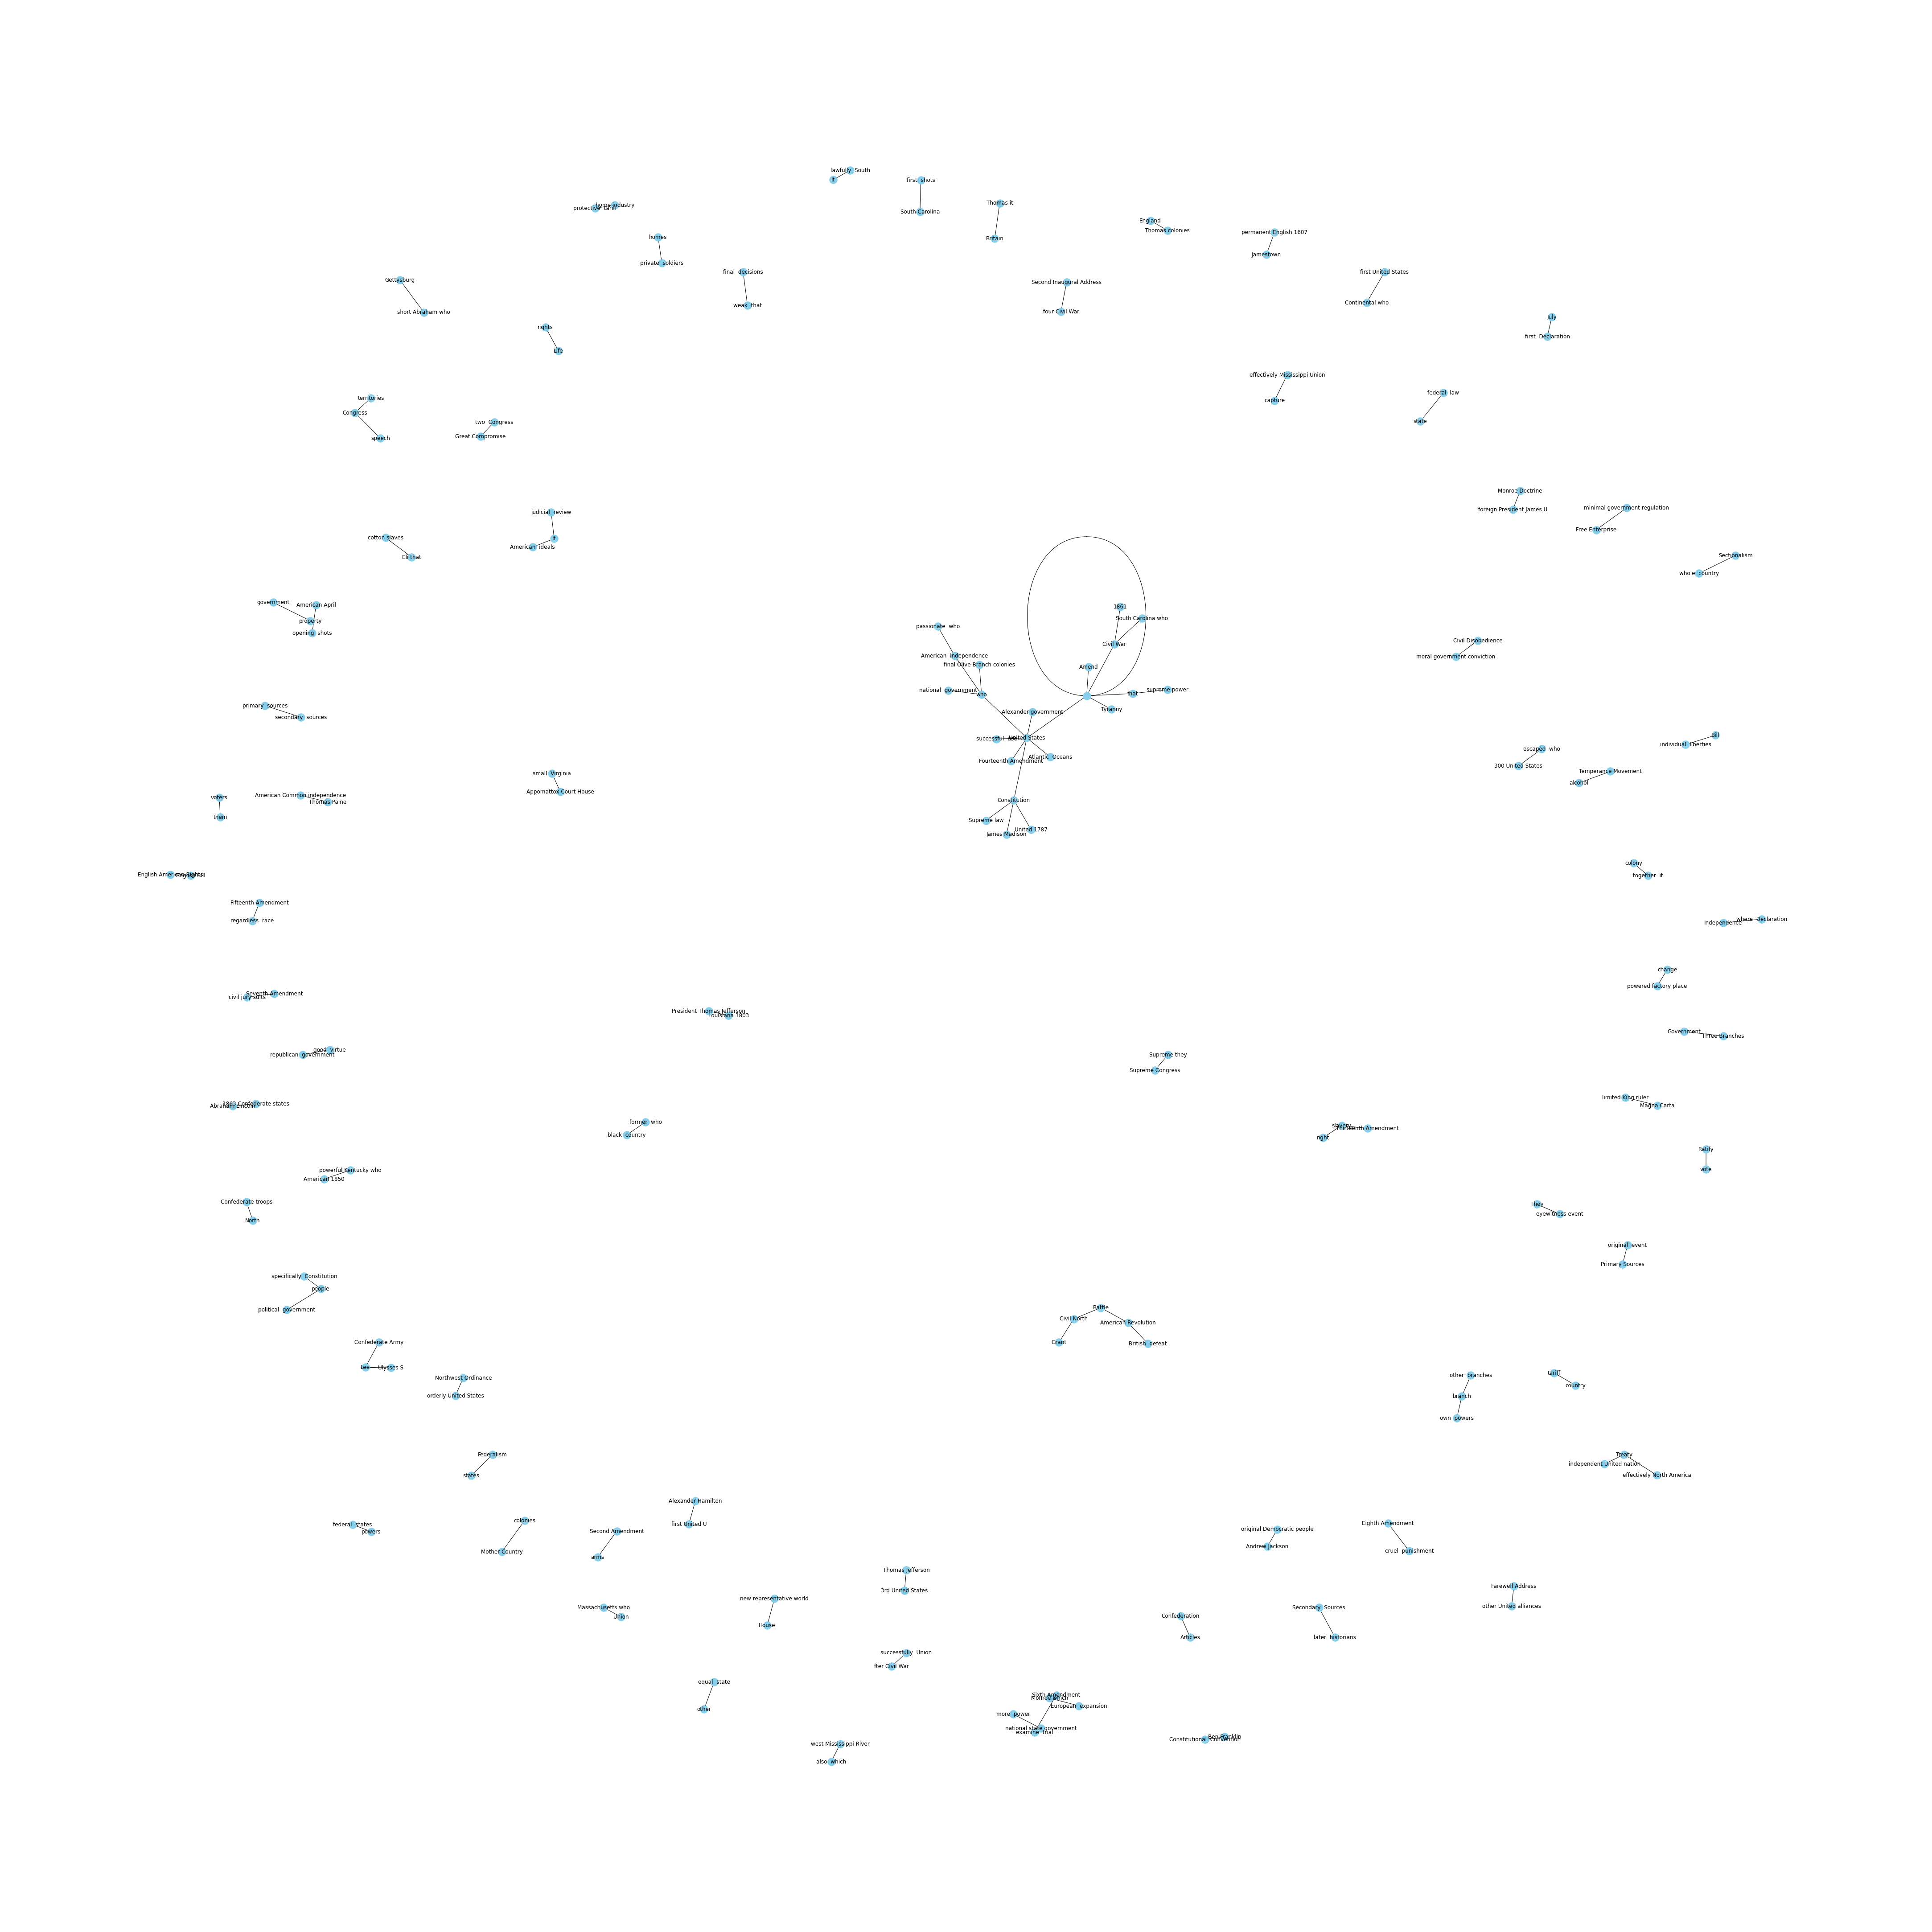

In [19]:

plt.figure(figsize=(60,60))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [20]:
for node in G.nodes():
    print(node, nx.degree_centrality(G)[node])
  

Jamestown 0.0053475935828877
permanent English 1607 0.0053475935828877
first  Declaration 0.0053475935828877
July 0.0053475935828877
Constitution 0.0213903743315508
United 1787 0.0053475935828877
President Thomas Jefferson 0.0053475935828877
Louisiana 1803 0.0053475935828877
Civil War 0.0160427807486631
1861 0.0053475935828877
opening  shots 0.0053475935828877
American April 0.0053475935828877
where  Declaration 0.0053475935828877
Independence 0.0053475935828877
Battle 0.0106951871657754
American Revolution 0.0106951871657754
British  defeat 0.0053475935828877
first  shots 0.0053475935828877
South Carolina 0.0053475935828877
Civil North 0.0106951871657754
Confederate troops 0.0053475935828877
North 0.0053475935828877
capture 0.0053475935828877
effectively Mississippi Union 0.0053475935828877
Appomattox Court House 0.0053475935828877
small  Virginia 0.0053475935828877
Lee 0.0106951871657754
Ulysses S 0.0053475935828877
 0.0374331550802139
colonies 0.0053475935828877
Mother Country 0.005

In [21]:
for node in G.nodes():
    print(node, nx.closeness_centrality(G, node))

Jamestown 0.0053475935828877
permanent English 1607 0.0053475935828877
first  Declaration 0.0053475935828877
July 0.0053475935828877
Constitution 0.04449601452931087
United 1787 0.0323053256171709
President Thomas Jefferson 0.0053475935828877
Louisiana 1803 0.0053475935828877
Civil War 0.03866047164022092
1861 0.029114676173499703
opening  shots 0.0053475935828877
American April 0.0053475935828877
where  Declaration 0.0053475935828877
Independence 0.0053475935828877
Battle 0.0142602495543672
American Revolution 0.012223071046600456
British  defeat 0.008556149732620321
first  shots 0.0053475935828877
South Carolina 0.0053475935828877
Civil North 0.012223071046600456
Confederate troops 0.0053475935828877
North 0.0053475935828877
capture 0.0053475935828877
effectively Mississippi Union 0.0053475935828877
Appomattox Court House 0.0053475935828877
small  Virginia 0.0053475935828877
Lee 0.0106951871657754
Ulysses S 0.0071301247771836
 0.052406417112299465
colonies 0.0053475935828877
Mother C

In [22]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

In [23]:
for node in G.nodes(): 
    print(node, nx.betweenness_centrality(G)[node])

Jamestown 0.0
permanent English 1607 0.0
first  Declaration 0.0
July 0.0
Constitution 0.003277557357253752
United 1787 0.0
President Thomas Jefferson 0.0
Louisiana 1803 0.0
Civil War 0.0022425392444367777
1861 0.0
opening  shots 0.0
American April 0.0
where  Declaration 0.0
Independence 0.0
Battle 0.00023000402507043874
American Revolution 0.00017250301880282904
British  defeat 0.0
first  shots 0.0
South Carolina 0.0
Civil North 0.00017250301880282904
Confederate troops 0.0
North 0.0
capture 0.0
effectively Mississippi Union 0.0
Appomattox Court House 0.0
small  Virginia 0.0
Lee 5.7501006267609686e-05
Ulysses S 0.0
 0.006612615720775114
colonies 0.0
Mother Country 0.0
who 0.004197573457535507
United States 0.009545167040423208
tariff 0.0
country 0.0
protective  tariff 0.0
home industry 0.0
Sectionalism 0.0
whole  country 0.0
Atlantic  Oceans 0.0
Temperance Movement 0.0
alcohol 0.0
voters 0.0
them 0.0
House 0.0
new representative world 0.0
Three Branches 0.0
Government 0.0
branch 5.7501

In [24]:
for node in G.nodes():
    print(node, nx.degree_centrality(G)[node])

Jamestown 0.0053475935828877
permanent English 1607 0.0053475935828877
first  Declaration 0.0053475935828877
July 0.0053475935828877
Constitution 0.0213903743315508
United 1787 0.0053475935828877
President Thomas Jefferson 0.0053475935828877
Louisiana 1803 0.0053475935828877
Civil War 0.0160427807486631
1861 0.0053475935828877
opening  shots 0.0053475935828877
American April 0.0053475935828877
where  Declaration 0.0053475935828877
Independence 0.0053475935828877
Battle 0.0106951871657754
American Revolution 0.0106951871657754
British  defeat 0.0053475935828877
first  shots 0.0053475935828877
South Carolina 0.0053475935828877
Civil North 0.0106951871657754
Confederate troops 0.0053475935828877
North 0.0053475935828877
capture 0.0053475935828877
effectively Mississippi Union 0.0053475935828877
Appomattox Court House 0.0053475935828877
small  Virginia 0.0053475935828877
Lee 0.0106951871657754
Ulysses S 0.0053475935828877
 0.0374331550802139
colonies 0.0053475935828877
Mother Country 0.005

In [25]:
for node in G.nodes():
    print(node, nx.closeness_centrality(G, node))

Jamestown 0.0053475935828877
permanent English 1607 0.0053475935828877
first  Declaration 0.0053475935828877
July 0.0053475935828877
Constitution 0.04449601452931087
United 1787 0.0323053256171709
President Thomas Jefferson 0.0053475935828877
Louisiana 1803 0.0053475935828877
Civil War 0.03866047164022092
1861 0.029114676173499703
opening  shots 0.0053475935828877
American April 0.0053475935828877
where  Declaration 0.0053475935828877
Independence 0.0053475935828877
Battle 0.0142602495543672
American Revolution 0.012223071046600456
British  defeat 0.008556149732620321
first  shots 0.0053475935828877
South Carolina 0.0053475935828877
Civil North 0.012223071046600456
Confederate troops 0.0053475935828877
North 0.0053475935828877
capture 0.0053475935828877
effectively Mississippi Union 0.0053475935828877
Appomattox Court House 0.0053475935828877
small  Virginia 0.0053475935828877
Lee 0.0106951871657754
Ulysses S 0.0071301247771836
 0.052406417112299465
colonies 0.0053475935828877
Mother C

In [26]:
for node in G.nodes(): 
    print(node, nx.eigenvector_centrality(G, max_iter=1000)[node])


Jamestown 4.706769989002046e-11
permanent English 1607 4.706769989002046e-11
first  Declaration 4.706769989002046e-11
July 4.706769989002046e-11
Constitution 0.2236232490923808
United 1787 0.06916387429815712
President Thomas Jefferson 4.706769989002046e-11
Louisiana 1803 4.706769989002046e-11
Civil War 0.22129651656466845
1861 0.06843261500650427
opening  shots 4.706769989002046e-11
American April 4.706769989002046e-11
where  Declaration 4.706769989002046e-11
Independence 4.706769989002046e-11
Battle 6.781293579886715e-07
American Revolution 5.872772510702339e-07
British  defeat 3.390646789943576e-07
first  shots 4.706769989002046e-11
South Carolina 4.706769989002046e-11
Civil North 5.872772510702339e-07
Confederate troops 4.706769989002046e-11
North 4.706769989002046e-11
capture 4.706769989002046e-11
effectively Mississippi Union 4.706769989002046e-11
Appomattox Court House 4.706769989002046e-11
small  Virginia 4.706769989002046e-11
Lee 1.6100499715732893e-08
Ulysses S 1.138477252948

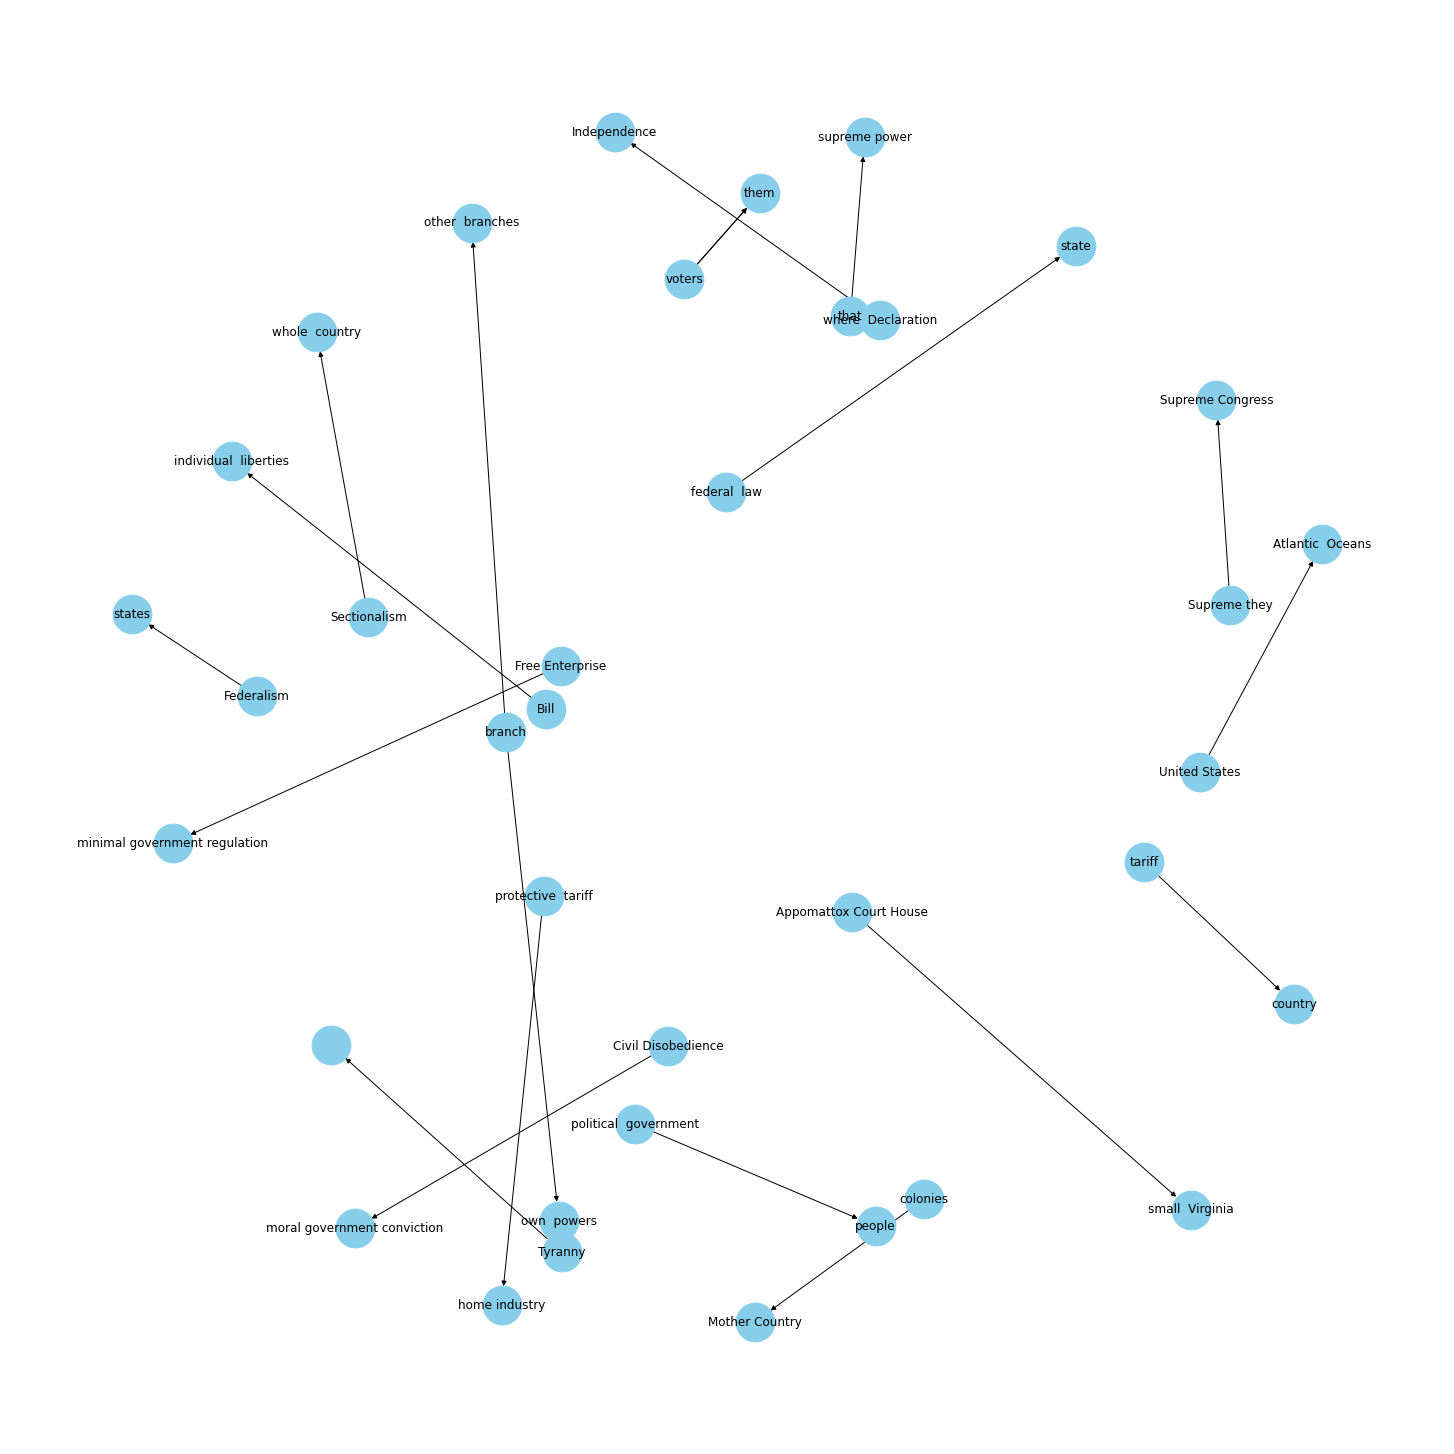

In [27]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

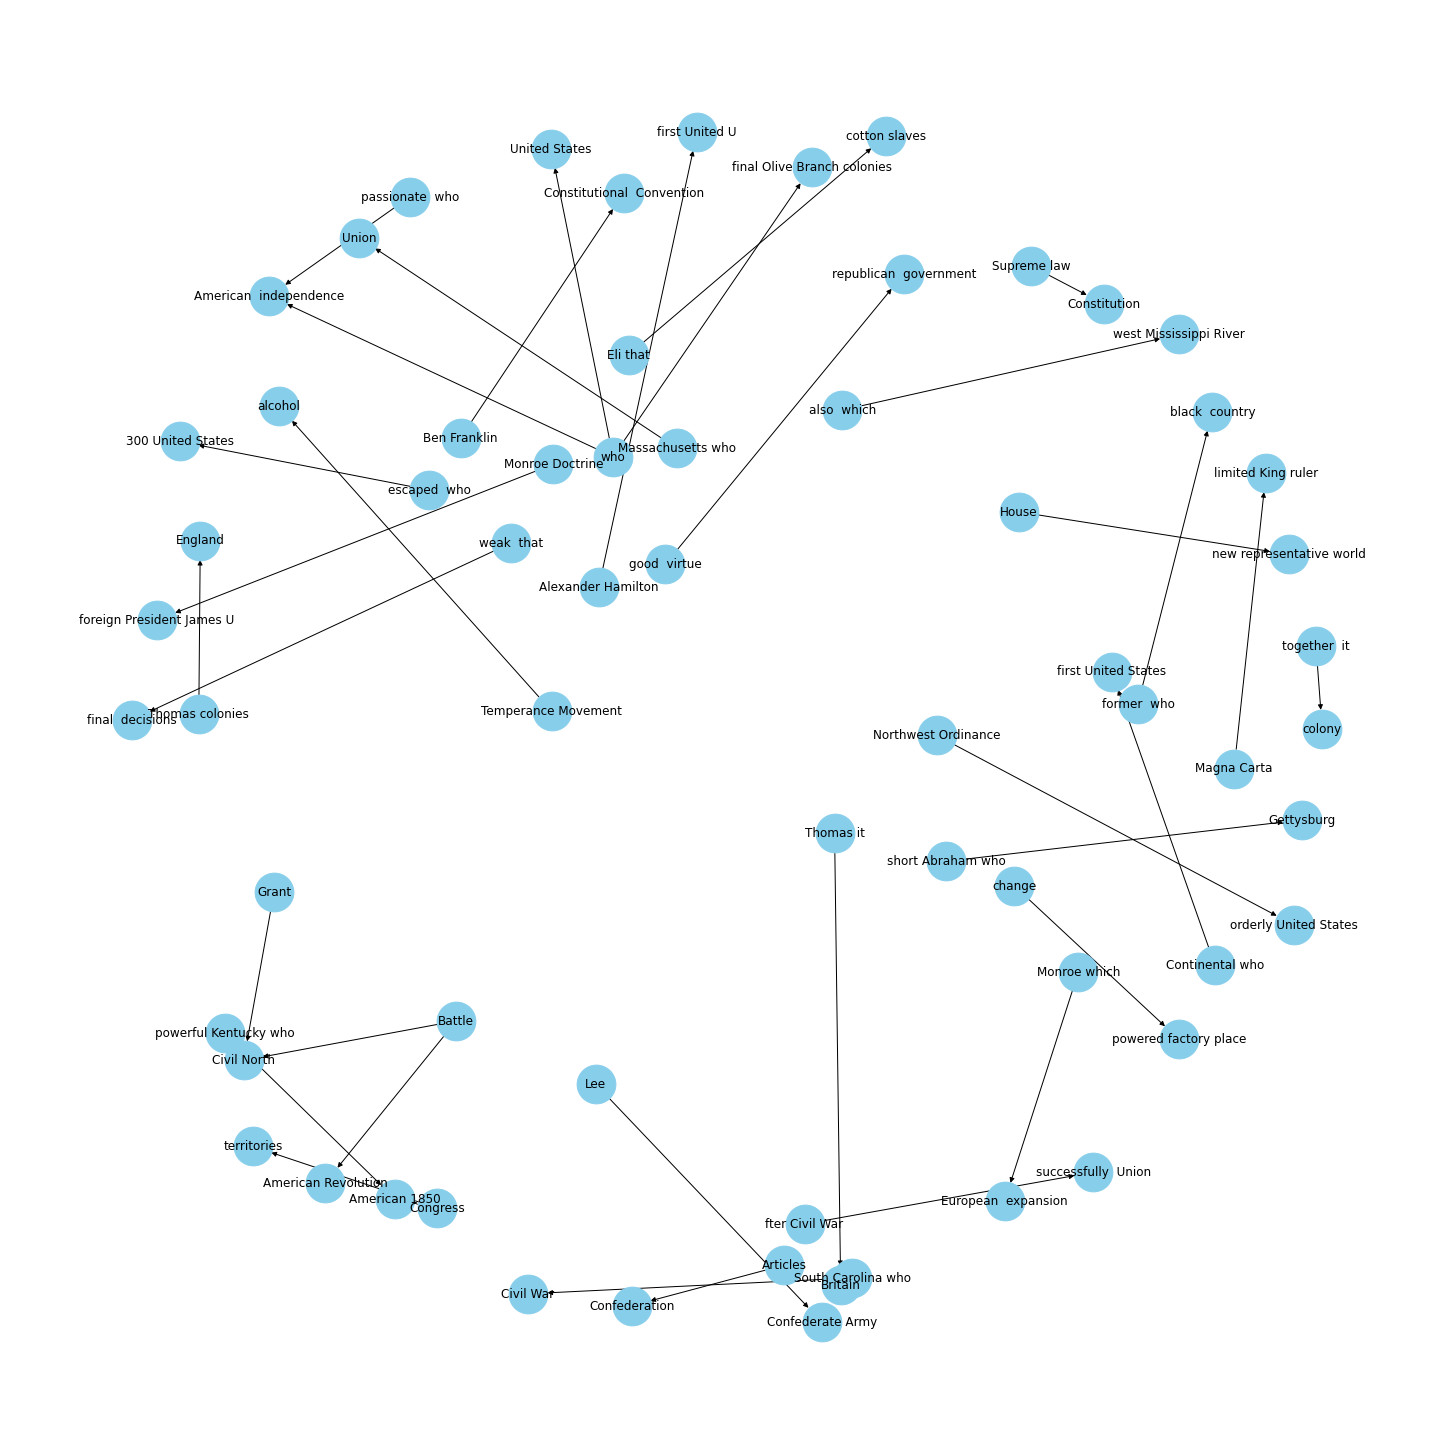

In [28]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# New

In [29]:
# Load the raw text.  #### Brownlee 5.25 p44
# Split into tokens.
# Convert to lowercase.
# Remove punctuation from each token.
# Filter out remaining tokens that are not alphabetic.
# Filter out tokens that are stop words.

import string

#loaddata
filename = "/content/drive/MyDrive/Chromebook DESK/NU MSDS/453 Natural Language/govdata.csv"
file=open(filename, 'rt')
text =file.read()
file.close()

#split into words
tokens = word_tokenize(text)

#convert to lowercase
tokens = [w.lower()for w in tokens]

#prepare regex for char filtering
re_punc = re.compile('[%s]' % re.escape(string.punctuation))

#remove punctuation from each word
stripped = [re_punc.sub('', w)for w in tokens]

#remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]

#filter out stopwords
stop_words =set(stopwords.words( 'english'))
words = [w for w in words if not w in stop_words]
print(words[:100])


NameError: ignored

In [ ]:
w2 = [word for word in tokens if len(word) > 4]

In [ ]:
len(w2)

In [ ]:
from collections import Counter

newcounts2 = Counter(w2)
newcounts2.most_common(20)

In [ ]:
#### Freq from clean doc

from collections import Counter

newcounts = Counter((words))
newcounts.most_common(20)